# The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2019 Semester 1
-----
## Project 2: Short Text Location Prediction
-----
###### Student Name(s): Qini ZHANG (901051)
###### Python version: Python 3
###### Submission deadline: 1pm, Friday 24 May 2019

## Import Libray and learners

In [4]:
# Import libraries
import nltk
import re
import string
import math
import pandas as pd
import numpy as np

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import metrics and evaluations
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

C:\Program Files\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Import learners

In [5]:
from sklearn.naive_bayes import *
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

In [6]:
geo = ['Sydney', 'Melbourne', 'Perth', 'Brisbane']
measure_distance = ['euclidean', 'cosine', 'manhattan']
# metrics = ['micro', 'macro', 'weighted', 'samples', 'weighted']

## Helper Functions

* Feature selection for raw data preprocessing

In [7]:
def remove_website(text):
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)#, flags=re.MULTILINE)
    return text

# def remove_number(text):
#     text = ''.join([i for i in text if not i.isdigit()])

# remove emoji but keep some special language character:
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)

## Load Dataset

In [8]:
# train_raw = pd.read_csv('./data/train-raw.tsv', sep = '\\t', header=0)
# train_raw['Text'] = train_raw['Text'].str.replace('[^\w\s]','')
# train_raw['Text'] = train_raw['Text'].str.replace('\"',' ')

# remove number
# train_raw['Text'] = train_raw['Text'].apply(lambda text: remove_number(text))

# remove unicode (include emoji and other language, turns out effect lower result)
# train_raw['Text'] = train_raw['Text'].apply(lambda text: ' '.join([i for i in text.split() if '\\' not in i]))

# remove emoji but keep other language
# train_raw['Text'] = train_raw['Text'].apply(lambda text: text.encode('ascii', 'ignore').decode('unicode_escape'))
# train_raw['Text'] = train_raw['Text'].apply(lambda text: remove_emoji(text))#.encode('unicode_escape').decode('ascii'))

# # remove website 
# train_raw['Text'] = train_raw['Text'].apply(lambda text: remove_web_site(text))
# train_raw.head()
# train_raw.shape

In [11]:
def read_data_eva(top):
    if top == '10':
        train_data = pd.read_csv("./data/train-top10.csv", index_col = 0)
        test_data = pd.read_csv("./data/dev-top10.csv", index_col=0)
    elif top == '50':
        train_data = pd.read_csv("./data/train-top50.csv", index_col = 0)
        test_data = pd.read_csv("./data/dev-top50.csv", index_col=0)
    elif top == '100':
        train_data = pd.read_csv("train-top100.csv", index_col = 0)
        test_data = pd.read_csv("dev-top100.csv", index_col=0)
    else:
        return None
    return train_data, test_data

def read_data_test(top):
    if top == '10':
        train_data = pd.read_csv("./data/train-top10.csv", index_col = 0)
        test_data = pd.read_csv("./data/test-top10.csv", index_col=0)
    elif top == '50':
        train_data = pd.read_csv("./data/train-top50.csv", index_col = 0)
        test_data = pd.read_csv("./data/test-top50.csv", index_col=0)
    elif top == '100':
        train_data = pd.read_csv("./data/train-top100.csv", index_col = 0)
        test_data = pd.read_csv("./data/test-top100.csv", index_col=0)
    else:
        return None
    return train_data, test_data

def preprocess(train_data, test_data):
    X_train, y_train = train_data[train_data.columns[:-1]], train_data['Location']
    X_test, y_test = test_data[test_data.columns[:-1]], test_data['Location']
    return X_train, y_train, X_test, y_test

In [15]:
# train_data, test_data = read_data_eva('100')
train_data, test_data = read_data_eva('100')
X_train, y_train, X_test, y_test = preprocess(train_data, test_data)

## Outcome Function

In [16]:
def outcome(clf, X_test):
    y_pred = clf.predict(X_test)
    
    df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels = geo), index = geo, columns = geo)
    
    sns.heatmap(df, annot = True, fmt = 'd')
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Real Label")
    plt.yticks(rotation=0)
    plt.show()
    print("======================================================")
    print(classification_report(y_test, y_pred, target_names = geo))
    print("======================================================")
    # ACC:
    acc = accuracy_score(y_pred, y_test)
    print("Acc: {:.2%}".format(acc))

## Initial Test (using preprocessed data provided)
### Baseline - MultinomialNB ->30.78%

In [17]:
clf2 = SGDClassifier(random_state=41, max_iter=1000, tol=None, n_jobs=-1).fit(X_train, y_train)
# outcome(clf2, X_test)

KeyboardInterrupt: 

In [ ]:
# outcome(clf2, X_test)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_pred, dev_raw['Location'])
print("Acc: {:.2%}".format(acc))

In [ ]:
clf = MultinomialNB().fit(X_train, y_train)
outcome(clf, X_test)

In [ ]:
clf = Bio

### test MNB

In [34]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Random Decision Forest Classifier -> 30.74%

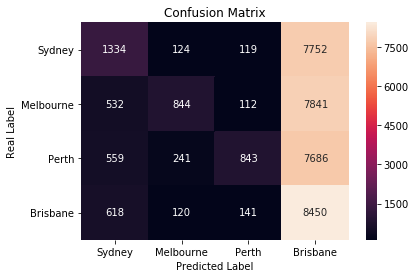

             precision    recall  f1-score   support

     Sydney       0.27      0.91      0.41      9329
  Melbourne       0.64      0.09      0.16      9329
      Perth       0.69      0.09      0.16      9329
   Brisbane       0.44      0.14      0.22      9329

avg / total       0.51      0.31      0.24     37316

Acc: 30.74%


In [18]:
clf = RandomForestClassifier().fit(X_train, y_train)

outcome(clf, X_test)

## Processing Raw dataset

In [86]:
dev_raw = pd.read_csv('./data/dev-raw.tsv', sep = '\\t', header=0)
test_raw = pd.read_csv('./data/test-raw.tsv', sep = '\\t', header=0)
train_raw = pd.read_csv('./data/train-raw.tsv', sep = '\\t', header=0)
# train_raw['Text'] = train_raw['Text'].str.replace('[^\w\s]','')
# train_raw['Text'] = train_raw['Text'].str.replace('\"',' ')

# remove unicode (include emoji and other language, turns out effect lower result)
# train_raw['Text'] = train_raw['Text'].apply(lambda text: ' '.join([i for i in text.split() if '\\' not in i]))

# remove emoji but keep other language
train_raw['Text'] = train_raw['Text'].apply(lambda text: text.encode('ascii', 'ignore').decode('unicode_escape'))
train_raw['Text'] = train_raw['Text'].apply(lambda text: remove_emoji(text).encode('unicode_escape').decode('ascii'))

# # remove website 
train_raw['Text'] = train_raw['Text'].apply(lambda text: remove_website(text))
# train_raw.shape
# train_raw.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel 

In [87]:
test_raw.head()

,Instance_ID,Location,Text
0,31,?,"""Awesome @evomagazine cover, time to dive in y..."
1,32,?,@InceptCruze goes 4-30 smfh
2,33,?,Sad loss to business &amp; sailing worlds. #RI...
3,34,?,@heavenlogin I would like my pokemon back in p...
4,35,?,#Hit30 Girls Talk Boys 5SOS


In [40]:
import nltk
# nltk.download('stopwords')
stop = set(stopwords.words('english'))

### Use `tfidf` with `Stocastic Gradient Descent`-> 34.60%

* dev 34.60% without stopwords
* add stopwords -> 34.55
* rm special character -> 34.17% => hell no

In [75]:
# tv = TfidfVectorizer(sublinear_tf=True)

tv = TfidfVectorizer(sublinear_tf=True, lowercase=True, analyzer='word', stop_words=stop, ngram_range=(1,1))
rclf = SGDClassifier(random_state=41, max_iter=1000, tol=None, n_jobs=-1)

In [76]:
tfid_train = tv.fit_transform(train_raw['Text'].values)

rclf.fit(tfid_train, train_raw["Location"].values)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=41, shuffle=True,
       tol=None, verbose=0, warm_start=False)

##### treat training dataset as testing set 87.15%

##### dev 34.60% without stopwords
##### add stopwords -> 34.55
##### rm special character -> 34.17% => hell no

In [77]:
dfid_test = tv.transform(dev_raw['Text'].values)
dy_pred = rclf.predict(dfid_test)
dy_test = dev_raw["Location"]
acc = accuracy_score(dy_pred, dy_test)
print("Acc: {:.2%}".format(acc))
# print((rcf.predict(dfid) == dev_top10["Location"]).mean())
print((rclf.predict(dfid_test) == dev_raw["Location"]).mean())

Acc: 34.00%
0.33998820881123376


## Using test_raw!

In [78]:
X_test_submit = tv.transform(test_raw['Text'].values)
y_pred_test = rclf.predict(X_test_submit)

In [79]:
output = test_raw[['Instance_ID']]
output['Class'] = y_pred_test
output.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(108148, 2)

In [80]:
output.columns = ['Id', 'Class']
output.head()

,Id,Class
0,31,Perth
1,32,Melbourne
2,33,Sydney
3,34,Sydney
4,35,Perth


In [66]:
output.to_csv('./data/temp.csv', index=False)

### Extract preprocessing data

In [70]:
clean_train = pd.DataFrame(tfid_train.toarray(), columns=tv.get_feature_names())
clean_train.head()

,00,000,00000000,000ana5,000ft,000kg,000km,000loza000,000m,000s,...,ᖇoᔕᔕᗩᑎ,ᖴoᖇ,ᗯᗩtᑕᕼiᑎg,ᗷᗩᕼᗩy,ᴍᴇ,ᴳᴬᴿᴮᴬᴳᴱ,ᵀʰᵃⁿᵏ,ᵒᶠ,ᵖᶦᵉᶜᵉ,⁷⁵
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
features = tv.get_feature_names()

In [72]:
len(features)

129169

In [57]:
# top 5%, 10%, 20%, 50%, 80%
# 5250, 10500, 21000, 52500, 84000
k_best = SelectKBest(chi2, k=100000).fit(tfid_train, y_train)
k_best_features = [features[i] for i in k_best.get_support(indices=True)]

# # output to text so we don't have to keep redoing this step...
# with open('best_features.txt', 'w') as f:
#     for item in k_best_features:
#         f.write("%s\n" % item)

In [58]:
k_best_features

['00000000',
 '000ana5',
 '000ft',
 '000kg',
 '000loza000',
 '000m',
 '000s',
 '000ดอลต',
 '001',
 '001182',
 '003a04f8c2054b7',
 '00477',
 '007pch',
 '008moonside',
 '009',
 '00mark86mark',
 '00pm',
 '00s',
 '00tipo',
 '01',
 '01000011cs',
 '011',
 '012',
 '0130',
 '0135',
 '014',
 '014209',
 '016',
 '01jack011',
 '01maincurang',
 '01menghalakansegalacara',
 '01pm',
 '01r',
 '01splcheck',
 '01untukindonesiamaju',
 '02',
 '0200',
 '022',
 '024',
 '0247',
 '02am',
 '03161ee000pc9a77',
 '0325jimin',
 '034',
 '0365',
 '039488',
 '0399357700',
 '04',
 '0400',
 '040419100087444',
 '0404553984',
 '0406south',
 '0408688390',
 '0410',
 '0410394497',
 '0414814900',
 '0421048291',
 '0421103786',
 '0422',
 '0422056021',
 '0428917888',
 '0430294110',
 '0438060971',
 '044',
 '0451640606',
 '0477',
 '048',
 '0487',
 '04pm',
 '04s',
 '05',
 '053',
 '05am',
 '05pm',
 '06',
 '06042019',
 '0620_kota',
 '0630',
 '06pm',
 '0715rita',
 '0731',
 '0731529572',
 '0731529573',
 '07nb',
 '07pm',
 '08',
 '084',
